In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel

SEED = 350107321 # from random.org
np.random.seed(SEED)

In [2]:
#Please find attached the time series data sets for optical trap calibration.
#'data_free.zip' contains both the passive and the driven data for a free bead in water.
#'data_PEO10.zip' contains both the passive and the driven data for a bead in concentrated PEO solution.
#The unit in the data sets is Volt. The conversion factor is about 1.11 micron/V.
#The sampling rate is 20 kHz.
#The driving frequency of the trap is about 41.6 Hz. 

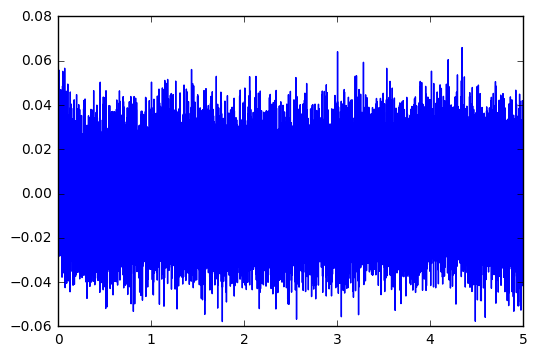

In [3]:
# load the data and subtract the mean
data = np.loadtxt("data_free/data_Free_passive_1.txt")*1.11
N = data.size
datan = data-data.mean()
delta_t = 1/20000
t = np.arange(N)*delta_t
plt.plot(t,datan)

0.02


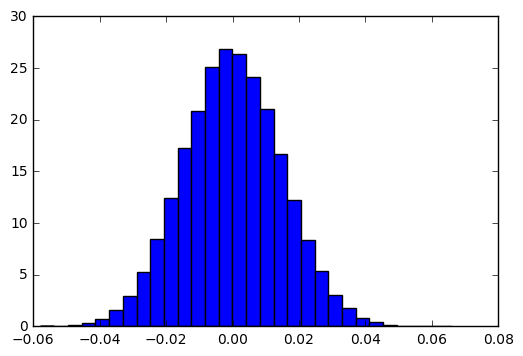

In [4]:
plt.hist(datan,bins=30,normed=True)
print(1/np.sqrt(N/40))

In [5]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

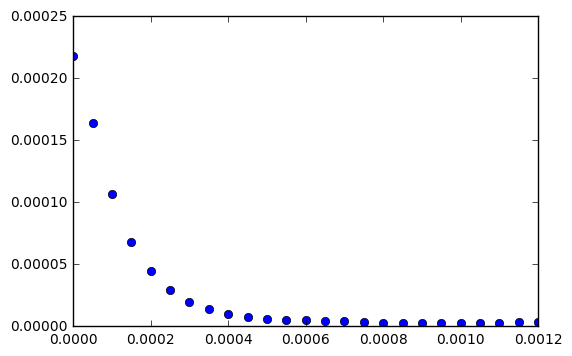

In [6]:
# calculate autocorrelation function
P = 25
f = np.fft.rfft(datan)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / N
autocorr = acf[int(N / 2):]

y = autocorr[:min(int(N / 2), P)]
t_acf = np.arange(min(int(N / 2), P))*delta_t
plt.plot(t_acf,y,"o")


In [7]:
mod = ExponentialModel()
pars = mod.guess(y, x=t_acf)
try:
    out = mod.fit(y, pars, x=t_acf)
except:
    fit_results = np.zeros(4)
    print('fit did not work')
else:
    print(out.fit_report(min_correl=0.25))


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 25
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -620.864
    Bayesian info crit = -618.426
[[Variables]]
    decay:       0.00013097 +/- 3.27e-06 (2.50%) (init= 0.0002882744)
    amplitude:   0.00022392 +/- 3.31e-06 (1.48%) (init= 7.265482e-05)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.564 



In [8]:
MLresults=OUresult(datan,delta_t)
print("Amplitude = ",MLresults[0],"+/-",MLresults[1],"(",MLresults[1]/MLresults[0]*100,"%)")
print("decay = ",MLresults[2],"+/-",MLresults[3],"(",MLresults[3]/MLresults[2]*100,"%)")

Amplitude =  0.000217795423001 +/- 1.85522064972e-06 ( 0.851818015342 %)
decay =  0.00017671853993 +/- 1.72293186358e-06 ( 0.974958181674 %)
